In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import time

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 4, "pin_memory": True}
    print("CUDA is supported")
else:
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [68]:
id_ch = {0:'$'}
ch_id = {'$':0}
idx = 1

for line in open('train.txt', mode='r'):
    if "<start>" in line:
        continue
    elif "<end>" in line:
        continue
    else:
        for ch in line:
            if ch not in ch_id:
                ch_id[ch] = idx
                id_ch[idx] = ch
                idx+=1

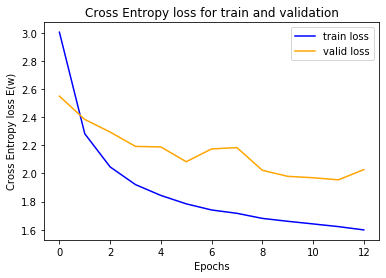

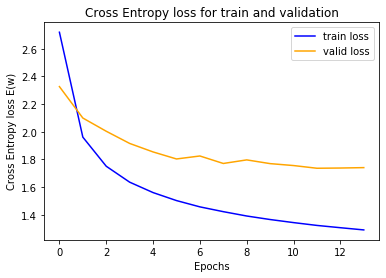

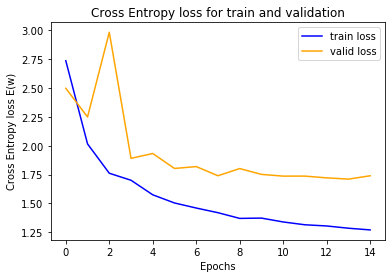

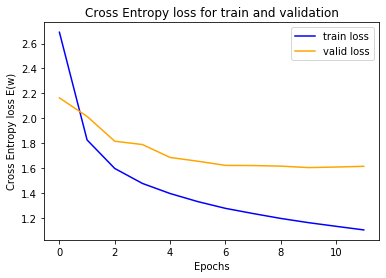

In [75]:
def plot(train_losses, valid_losses):
    plt.plot(train_losses, color='blue', label='train loss')
    plt.plot(valid_losses, color='orange', label='valid loss')
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy loss E(w)")
    plt.legend(loc='upper right')
    plt.title("Cross Entropy loss for train and validation")
    plt.show()

In [116]:
def predictNext(model, char, maximum = False, T = 1):
    sm = nn.Softmax(dim = 0)
    if maximum:
        return model.forward(char.to(device))[-1].max(0)[1].item()
    else:
        return np.random.choice(94, p = sm(model.forward(char.to(device))[-1] / T).cpu().detach().numpy())

def toHot(notes):
    hot = torch.zeros(1, len(notes), 94, dtype=torch.float)
    for i in range(len(notes)):
        hot[0][i][ch_id[notes[i]]] = 1
    return hot

def generateSong(model, maximum = False, T = 1):
    notes = "X:"
    model.init_hidden()
    char = 1
    predictNext(model, toHot(notes), maximum, T)
    
    while char != 0 and len(notes) < 500:
        input = toHot(notes[-1])
        char = predictNext(model, input, maximum, T)
        notes += id_ch[char]
        
    return notes

class LSTM(nn.Module): 
    def __init__(self, input_size, hidden_size, num_layers, num_classes): 
        super(LSTM, self).__init__() 
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.init_hidden()
    
    def forward(self, input):
        """
        Args:
            input  : [seq_len, batch_size, input_]
        Returns:
            out    : [seq_len, batch_size, hidden_size]
        """
        out, (self.hs, self.cs) = self.lstm(input, (self.hs.detach(), self.cs.detach()))
        return self.fc(out.view(-1, self.hidden_size))
    
    def init_hidden(self):
        """
        Returns:
            hidden : [layer_len, batch_size, hidden_size] * 2 (pair)
        """
        self.hs = Variable(torch.zeros(self.num_layers, 1, self.hidden_size)).float().to(device)
        self.cs = Variable(torch.zeros(self.num_layers, 1, self.hidden_size)).float().to(device)

class dataset(Dataset):
    """
    Attirbutes
        data     : list of [idx, string] - 1
        one_hot
    """
    def __init__(self, txt_file, id_ch, ch_id):
        """
        Args
            txt_file  : location of txt file
            root_dir  : root directory for images
        """
        self.data = [""]
        self.id_ch = id_ch
        self.ch_id = ch_id
        self.dim = len(id_ch)

        ne = 0
        for line in open(txt_file, mode='r'):
            if "<start>" in line:
                continue
            elif "<end>" in line:
                self.data.append("")
            else:
                self.data[len(self.data) - 1] += line
        self.data.pop()
        
        self.computed = []
        
        for i in range(len(self.data)):
            item = self.computeItem(i)
            self.computed.append(item)

    def __len__(self):
        return len(self.data)
    
    def computeItem(self, idx):
        indices = [ch_id[ch] for ch in self.data[idx]]
        targets = np.array(indices).reshape(-1)
        one_hot = np.eye(self.dim)[targets]
        label = np.zeros(one_hot.shape[0], dtype=np.int64)
        label[0:label.shape[0]-1] = one_hot.argmax(axis=1)[1:one_hot.shape[0]] # shifted one to left
        label[label.shape[0]-1] = ch_id['$'] # for end character
        return (one_hot, label)

    def __getitem__(self, idx):
        return self.computed[idx]

In [117]:
model = LSTM(input_size = 94, hidden_size = 150, num_layers = 1, num_classes = 94).to(device)
model.load_state_dict(torch.load("IV/14"))

<All keys matched successfully>

In [169]:
print(generateSong(model, True))

X:1
T:La courelle
R:Branle de caracoie
O:France
A:Provence
C:?
R:Parole
C:Trad.
S:Carnet du tambourinaire Ginas (1924)
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-25
Z:Pour toute observation mailto:galouvielle@free.fr
M:2/4
L:1/8
K:Bb
V:Galoubet
B B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 |
